In [1]:
import pandas as pd
import requests
from io import StringIO
import tensorflow
import keras
import sklearn
import pickle

In [2]:
# Prepare data set
df = pd.read_csv('train_preprocess.tsv', sep='\t', header=None, names = ['Text', 'Kategori']) 
df.head()

,Text,Kategori
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [3]:
df.Kategori.value_counts()

Kategori
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64

## Text Cleansing

In [4]:
import re 

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [5]:
# Menambahkan kolom text clean
df['text_clean'] = df.Text.apply(cleansing)
df.head()

,Text,Kategori,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung t...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kas...


In [6]:
neg = df.loc[df['Kategori'] == 'negative'].text_clean.tolist()
neu = df.loc[df['Kategori'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['Kategori'] == 'positive'].text_clean.tolist()

neg_sentiment = df.loc[df['Kategori'] == 'negative'].Kategori.tolist()
neu_sentiment = df.loc[df['Kategori'] == 'neutral'].Kategori.tolist()
pos_sentiment = df.loc[df['Kategori'] == 'positive'].Kategori.tolist()

In [7]:
total_data = pos + neu + neg
labels = pos_sentiment + neu_sentiment + neg_sentiment

In [8]:
total_data[0]

'warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung   tahu berkualitas   dipadu keahlian memasak   dipadu kretivitas   jadilah warung yang menyajikan menu utama berbahan tahu   ditambah menu umum lain seperti ayam   semuanya selera indonesia   harga cukup terjangkau   jangan lewatkan tahu bletoka nya   tidak kalah dengan yang asli dari tegal  '

In [9]:
#Tokenizing and Applying pad_sequences

import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)

with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('tokenizer.pickle has been created.')

X = tokenizer.texts_to_sequences(total_data)
X = pad_sequences(X)

with open('x_pad_sequences.pickle','wb') as handle:
  pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has been created.')

tokenizer.pickle has been created.
x_pad_sequences.pickle has been created.


In [10]:
len(labels)

11000

In [11]:
Y = pd.get_dummies(labels)
Y = Y.values

print(Y)

[[False False  True]
 [False False  True]
 [False False  True]
 ...
 [ True False False]
 [ True False False]
 [ True False False]]


In [12]:
with open('y_labels.pickle','wb') as handle:
  pickle.dump(Y,handle, protocol=pickle.HIGHEST_PROTOCOL)
  print("y_labels.pickle has been created")

y_labels.pickle has been created


In [13]:
Y.shape

(11000, 3)

In [14]:
Y[0:10]

array([[False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True]])

In [15]:
some_df = pd.DataFrame(data=Y, columns=['a','b','c'])
some_df.head()

,a,b,c
0,False,False,True
1,False,False,True
2,False,False,True
3,False,False,True
4,False,False,True


In [16]:
some_df['labels'] = labels
some_df.head()

,a,b,c,labels
0,False,False,True,positive
1,False,False,True,positive
2,False,False,True,positive
3,False,False,True,positive
4,False,False,True,positive


In [17]:
some_df[some_df['labels']=='negative'].iloc[0:1]

,a,b,c,labels
7564,True,False,False,negative


In [18]:
some_df[some_df['labels']=='neutral'].iloc[0:1]

,a,b,c,labels
6416,False,True,False,neutral


In [19]:
some_df[some_df['labels']=='positive'].iloc[0:1]

,a,b,c,labels
0,False,False,True,positive


In [20]:
from sklearn.model_selection import train_test_split

In [21]:
file = open("x_pad_sequences.pickle",'rb')
x = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
y = pickle.load(file)
file.close()

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=1)

In [22]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
embed_dim = 100
units = 64

model=Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

adam=optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(x_train, y_train, epochs=2, batch_size=12, validation_data=(x_test, y_test), verbose=1, callbacks=[es])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10042435 (38.31 MB)
Trainable params: 10042435 (38.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/2



734/734 [==============================] - 88s 113ms/step - loss: 0.4650 - accuracy: 0.8119 - val_loss: 0.3288 - val_accuracy: 0.8805
Epoch 2/2
734/734 [==============================] - 88s 120ms/step - loss: 0.2000 - accuracy: 0.9282 - val_loss: 0.3530 - val_accuracy: 0.8814
Epoch 2: early stopping


In [24]:
from sklearn import metrics

predictions = model.predict(x_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 2s 21ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       685
           1       0.88      0.76      0.81       233
           2       0.91      0.91      0.91      1282

    accuracy                           0.88      2200
   macro avg       0.87      0.84      0.86      2200
weighted avg       0.88      0.88      0.88      2200



In [25]:
model.save('model.h5')
print('Model has been created.')

g:\Pribadi\Andi\Challenge_Platinum\challenge_platinum\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model has been created.


In [26]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y=Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X),start=1):

    data_train = X[data[0]]
    target_train = y[data[0]]

    data_test = X[data[1]]
    target_test = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units,dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

    adam = optimizers.Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=adam,metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history= model.fit(x_train,y_train,epochs=10,batch_size=10,validation_data=(x_test,y_test),verbose=0,callbacks=[es])

    predictions = model.predict(x_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1) ))
    print("===================================================================")

    accuracies.append(accuracy)

average_accuracy= np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

69/69 [==============================] - 2s 23ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       685
           1       0.80      0.77      0.79       233
           2       0.90      0.93      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.85      0.83      0.84      2200
weighted avg       0.87      0.87      0.87      2200



69/69 [==============================] - 1s 13ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       685
           1       0.79      0.79      0.79       233
           2       0.91      0.91      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.84      0.84      0.84      2200
weighted avg       0.87      0.87      0.87      2200



69/69 [==============================] - 1s 12ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       685
           1       0.80      0.79      0.79       233
           2       0.89      0.94      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.85      0.83      0.84      2200
weighted avg       0.87      0.87      0.87      2200



69/69 [==============================] - 2s 20ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       685
           1       0.86      0.73      0.79       233
           2       0.86      0.95      0.90      1282

    accuracy                           0.86      2200
   macro avg       0.86      0.81      0.83      2200
weighted avg       0.86      0.86      0.86      2200



69/69 [==============================] - 2s 16ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       685
           1       0.86      0.75      0.80       233
           2       0.93      0.89      0.91      1282

    accuracy                           0.88      2200
   macro avg       0.86      0.84      0.85      2200
weighted avg       0.88      0.88      0.88      2200




Rata-rata Accuracy:  0.869909090909091


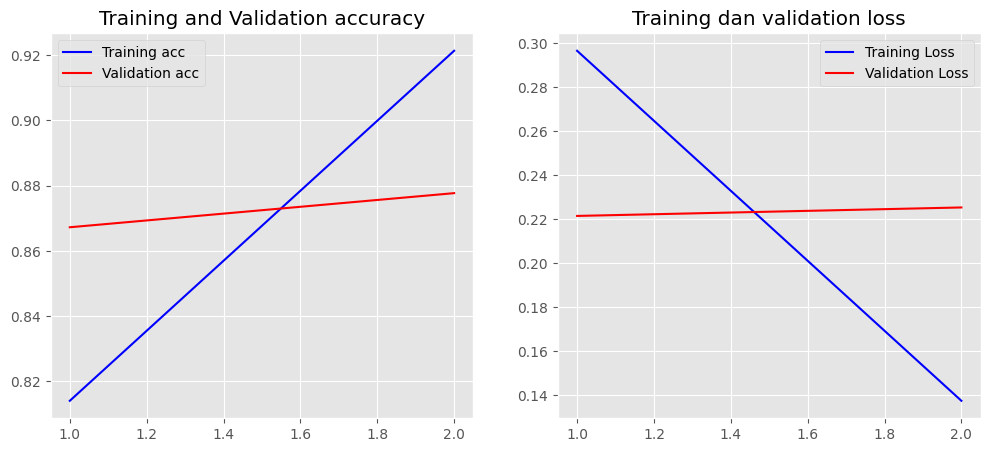

In [32]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(x,acc,'b',label='Training acc')
    plt.plot(x,val_acc,'r',label = 'Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(x,loss,'b',label='Training Loss')
    plt.plot(x,val_loss,'r',label='Validation Loss')
    plt.title('Training dan validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [33]:
import re
from keras.models import load_model

input_text = """
Rasa syukur, cukup.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 2s 2s/step
Text:   rasa syukur  cukup  
Sentiment:  positive
